In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations

In [13]:
df1 = pd.DataFrame({'node':['1','2','3','4','5','6','7','8'],
                                     'demand':[-600,-300,-500,-400,400,500,400,400]})
df1

,node,demand
0,1,-600
1,2,-300
2,3,-500
3,4,-400
4,5,400
5,6,500
6,7,400
7,8,400


In [14]:
if df1['demand'].sum() !=0:
    df1.loc[df1.shape[0]+1,'demand']=-(df1['demand'].sum())
    df1.loc[df1.shape[0],'node']='dummy'
df1

,node,demand
0,1,-600.0
1,2,-300.0
2,3,-500.0
3,4,-400.0
4,5,400.0
5,6,500.0
6,7,400.0
7,8,400.0
9,dummy,100.0


In [15]:
# If 'dummy' is negative
if df1[df1['node'] == 'dummy']['demand'].values[0] < 0:
    # Create the DataFrame for positive values
    dummy_df = df1[df1['demand'] > 0].copy()
    dummy_df['source'] = 'dummy'
    dummy_df['cost'] = 0
    dummy_df = dummy_df.rename(columns={'node': 'destination'})
    dummy_df=dummy_df.drop('demand',axis=1)
else:
    # Create the DataFrame for negative values
    dummy_df = df1[df1['demand'] < 0].copy()
    dummy_df['destination'] = 'dummy'
    dummy_df['cost'] = 0
    dummy_df = dummy_df.rename(columns={'node': 'source'})
    dummy_df=dummy_df.drop('demand',axis=1)

In [16]:
df2 = pd.DataFrame({
    'source':['1','2','3','4','5','6','7'],
    'destination':['5','6','7','8','6','7','8'],
    'cost':[2,5,3,3,0.25,0.25,0.25]})
df2=pd.concat([df2,dummy_df])
#pd.merge(left=df2,right=df1,how='left',left_on='source',right_on='source_node')
df2

,source,destination,cost
0,1,5,2.00
1,2,6,5.00
2,3,7,3.00
3,4,8,3.00
4,5,6,0.25
5,6,7,0.25
6,7,8,0.25
0,1,dummy,0.00
1,2,dummy,0.00
2,3,dummy,0.00


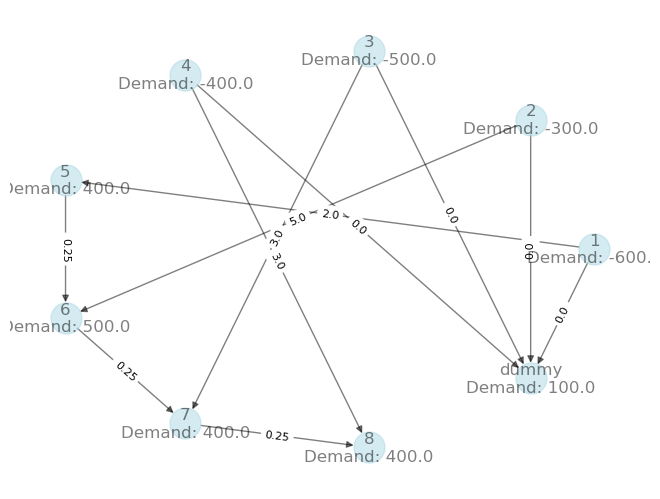

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


# Create a directed graph (DiGraph)
G = nx.DiGraph()

# Add nodes with demand as node attribute
for _, row in df1.iterrows():
    G.add_node(row['node'], demand=row['demand'])

# Add edges with weights (costs)
for _, row in df2.iterrows():
    G.add_edge(row['source'], row['destination'], weight=row['cost'])

# Create a layout for the nodes
pos = nx.circular_layout(G)

# Draw the nodes with labels (including demand values)
node_labels = {node: f"{node}\nDemand: {G.nodes[node]['demand']}" for node in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=500, node_color='lightblue',alpha=0.5)

# Draw the edges with weights as labels
edge_labels = {(edge[0], edge[1]): G[edge[0]][edge[1]]['weight'] for edge in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Show the graph
plt.show()

In [18]:
G = nx.DiGraph()
# Add nodes with demands
for _, row in df1.iterrows():
    
    G.add_node(row['node'], demand=row['demand'])

# Add edges with weights (costs)
for _, row in df2.iterrows():
    G.add_edge(row['source'], row['destination'], weight=row['cost'])
flowCost,flowDict = nx.network_simplex(G)
print(flowDict)
print(flowCost)

{'1': {'5': 600.0, 'dummy': 0.0}, '2': {'6': 300.0, 'dummy': 0.0}, '3': {'7': 400.0, 'dummy': 100.0}, '4': {'8': 400.0, 'dummy': 0}, '5': {'6': 200.0}, '6': {'7': 0}, '7': {'8': 0.0}, '8': {}, 'dummy': {}}
5150.0


In [19]:
import pandas as pd

# Convert the flowDict dictionary to a DataFrame
df = pd.DataFrame.from_dict(flowDict, orient='index').fillna(0)

# Reset the index to have 'source' as a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'source'}, inplace=True)

# Melt the DataFrame to have 'source', 'destination', and 'flow' columns
df_melted = pd.melt(df, id_vars='source', var_name='destination', value_name='flow')
df_melted=df_melted[df_melted['flow']!=0]
df_melted=pd.merge(left=df_melted,right=df2,how='inner',on=['source','destination'])
df_melted['TotCost']=df_melted['flow']*df_melted['cost']
df_melted

,source,destination,flow,cost,TotCost
0,1,5,600.0,2.00,1200.0
1,3,dummy,100.0,0.00,0.0
2,2,6,300.0,5.00,1500.0
3,5,6,200.0,0.25,50.0
4,3,7,400.0,3.00,1200.0
5,4,8,400.0,3.00,1200.0


In [20]:
df_melted['TotCost'].sum()

5150.0

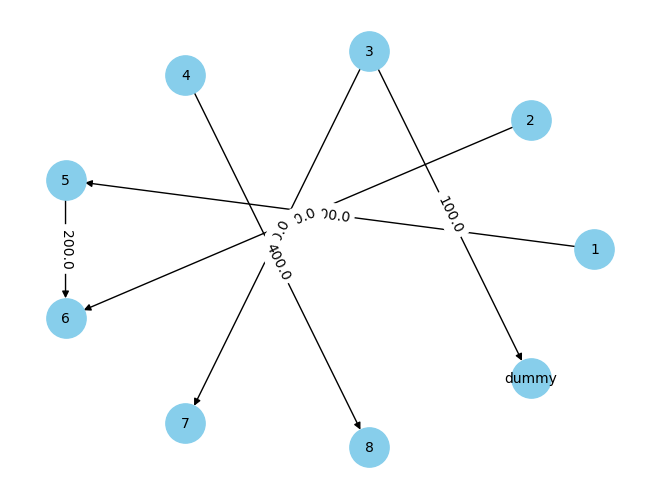

In [21]:
# Create an empty directed graph
G = nx.DiGraph()

# Add nodes to the graph
nodes = flowDict.keys()
G.add_nodes_from(nodes)

# Add edges with non-zero values
for source, destinations in flowDict.items():
    for destination, value in destinations.items():
        if value != 0:
            G.add_edge(source, destination, weight=value)

# Draw the graph
pos = nx.circular_layout(G)  # You can choose a different layout if you prefer
edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}

nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.show()

In [53]:
# In the final analysis we can ignore the values assigned to dummy variables